<a href="https://colab.research.google.com/github/filipp134/vk_bot_detection/blob/first_vers/vk_bot_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Каждые 24 часа нужно пройти по AUTHORIZATION_LINK, чтобы получить ACCESS_TOKEN

In [ ]:
import requests
import networkx as nx

BASIC_LINK = 'https://api.vk.com/method/'
ACCESS_TOKEN = ''

In [ ]:
def friends_ids_receiver():
  '''Получение списка id друзей пользователя ВКонтакте с user_id.'''
  method = 'friends.get'
  payload = {'user-id' : 36414701,
  'order':'name',
  'count' : 1000,
  'offset' : 1,
  'fields': ','.join(['city','domain','nickname', 'sex', 'education', 'last_seen']),
  'name_case' : 'nom',
  'v':'5.130',
  'access_token' : ACCESS_TOKEN}
  print(payload)
  response = requests.get(BASIC_LINK + method, params=payload).json()
  print(response)
  friends_ids = []
  for i in range(0, len(response['response']['items'])):
    friends_ids.append(response['response']['items'][i]['id'])
  return friends_ids

In [ ]:
def make_connection(edge1, edge2, graph):
  '''Проведение ребра в обе стороны. edge1, edge2 - вершины. graph - граф.'''
  graph.add_edge(edge1, edge2)
  graph.add_edge(edge2, edge1)

36414701
[36414701, 349141859, 411664440]
349141859
[36414701, 349141859, 411664440]
411664440
[36414701, 349141859, 411664440]


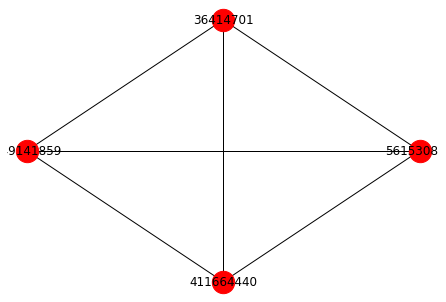

In [ ]:
graph = nx.Graph()
my_id = '561530855'
friends_ids = friends_ids_receiver(my_id)
graph.add_node(my_id)
for i in range(0, len(friends_ids)):
  graph.add_node(friends_ids[i])
  make_connection(my_id, friends_ids[i], graph)
for i in range(0, len(friends_ids)):
  user_id = friends_ids[i]
  print(user_id)
  friends_ids_2nd_gen = friends_ids_receiver(user_id)
  print(friends_ids_2nd_gen)
  for j in range(0, len(friends_ids_2nd_gen)):
    if friends_ids_2nd_gen[j] in friends_ids:
      make_connection(friends_ids_2nd_gen[j], friends_ids[i], graph)
nx.draw_circular(graph, node_color='red', node_size=500, with_labels=True)

In [ ]:
b = friends_ids_receiver()
b

{'user-id': 36414701, 'order': 'name', 'count': 1000, 'offset': 1, 'fields': 'city,domain,nickname,sex,education,last_seen', 'name_case': 'nom', 'v': '5.130', 'access_token': '47b617800069aa15dbc6939162987605ed7d3acc712782df06c60d1927360bc79e39914ca2848994491f1'}
{'response': {'count': 4, 'items': [{'first_name': 'Михаил', 'id': 36414701, 'last_name': 'Фролычев', 'can_access_closed': True, 'is_closed': False, 'sex': 2, 'nickname': '', 'domain': 'id36414701', 'city': {'id': 1386, 'title': 'Сергиев Посад'}, 'last_seen': {'platform': 4, 'time': 1614177886}, 'university': 0, 'university_name': '', 'faculty': 0, 'faculty_name': '', 'graduation': 0, 'track_code': '0e4aacbejUGLdzFt13SETd7asy0JM7k_67s4WlCWlgXEG8vSgWDgKoNBDG-Cd4JL6UlIitFV2TL8oF00'}, {'first_name': 'Пётр', 'id': 349141859, 'last_name': 'Федосов', 'can_access_closed': True, 'is_closed': False, 'sex': 2, 'nickname': '', 'domain': 'petr.fedosov', 'city': {'id': 1, 'title': 'Москва'}, 'last_seen': {'platform': 7, 'time': 1614188534}

[36414701, 349141859, 411664440]